In [1]:
import torch
from torchtext.data import Field,TabularDataset,LabelField,BucketIterator
import pandas as pd

#### Convert raw reviews data into dataframe, split to train and valid dataset then save to .csv

In [2]:
filename="reviews_labeled.txt"

#Convert text file into dataframe
file=open(filename,"r")
df=pd.DataFrame()
for line in file:
    text,label=line.split('|')
    df=df.append(pd.DataFrame({'review':text,'label':int(label)},index=[0]))

df=df.reset_index()
del df['index']

#Shuffle rows in dataframe
from sklearn.utils import shuffle
df = shuffle(df)
split_ratio=0.8
train,valid=df[:int(split_ratio*len(df))],df[int(split_ratio*len(df)):]

#Check if negative/positive rows are distributed equally
print(train['label'].value_counts())
print(valid['label'].value_counts())

#Export to .csv
train.to_csv('train.csv',index=False)
valid.to_csv('valid.csv',index=False)

0    4318
1    4211
Name: label, dtype: int64
1    1120
0    1013
Name: label, dtype: int64


In [3]:
df.head(10) #Show how dataframe looks like

,review,label
1586,if the movie succeeds in instilling a wary sen...,0
3034,half of it is composed of snappy patter and ps...,0
5542,a rare beautiful film,1
7980,film aficionados cannot help but love cinema ...,1
7270,plays out with a dogged and eventually winning...,1
1536,too much of the humor falls flat,0
7665,the premise of jason x is silly but strangely ...,1
1931,to say this was done better in wilder s some l...,0
4531,in his role of observer of the scene lawrence ...,0
8217,the movie is amateurish but it s a minor treat,1


#### Load .csv into torch object 

In [4]:
TEXT=Field(tokenize='spacy',include_lengths = True)
LABEL =LabelField(dtype=torch.float)

datafield=[('review',TEXT),('label',LABEL)]
train,valid=TabularDataset.splits(path='',train='train.csv',validation='valid.csv',format='csv',skip_header=True,
                                  fields=datafield)

print(f'Number of training examples: {len(train)}')
print(f'Number of testing examples: {len(valid)}')

Number of training examples: 8529
Number of testing examples: 2133


#### Build vocabolary and keep only the most 10000 frequent words

In [5]:
MAX_VOCAB_SIZE=10_000
TEXT.build_vocab(train, max_size = MAX_VOCAB_SIZE,
                 vectors='glove.6B.100d',
                 unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train)

In [6]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator = BucketIterator.splits(
    (train, valid), 
    batch_size =BATCH_SIZE,
    device = device,
    sort_key=lambda x:len(x.review),
    sort_within_batch=False,
    repeat=False)

#### Build RNN architecture

In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,enforce_sorted=False)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))           
        return self.fc(hidden.squeeze(0))
    
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [8]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX=TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX]=torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX]=torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

torch.Size([10002, 100])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0551,  0.2630,  0.7239,  ...,  0.0720, -0.8072,  0.3240],
        [-0.2553,  0.1879, -0.0932,  ..., -0.3239,  0.4157,  0.7228],
        [ 0.3005, -0.4397,  0.3765,  ..., -0.5349,  0.9316,  0.5556]])


#### Select optimizer and criterion

In [9]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

#### Train, Evaluate, Accuracy measurement function

In [10]:
def binary_accuracy(preds, y):
    rounded_pred =torch.round(torch.sigmoid(preds))
    correct=(rounded_preds == y).float() 
    acc=correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    epoch_loss=0
    epoch_acc=0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.review
        predictions = model(text,text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss=0
    epoch_acc=0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text,text_lengths=batch.review
            predictions=model(text,text_lengths).squeeze(1)
            loss=criterion(predictions, batch.label)
            acc=binary_accuracy(predictions, batch.label)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

import time
def epoch_time(start_time, end_time):
    elapsed_time=end_time-start_time
    elapsed_mins=int(elapsed_time/60)
    elapsed_secs=int(elapsed_time-(elapsed_mins*60))
    return elapsed_mins,elapsed_secs

#### Train the model

In [11]:
N_EPOCHS = 10

best_valid_loss = float('inf')
valid_a=[]
train_a=[]
valid_l=[]
train_l=[]
for epoch in range(N_EPOCHS):

    start_time=time.time()
    
    train_loss,train_acc=train(model, train_iterator, optimizer, criterion)
    valid_loss,valid_acc=evaluate(model, valid_iterator, criterion)
    
    end_time=time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    valid_a.append(valid_acc)
    train_a.append(train_acc)
    valid_l.append(valid_loss)
    train_l.append(train_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 42s
	Train Loss: 0.622 | Train Acc: 64.17%
	 Val. Loss: 0.525 |  Val. Acc: 73.23%
Epoch: 02 | Epoch Time: 2m 44s
	Train Loss: 0.523 | Train Acc: 73.85%
	 Val. Loss: 0.462 |  Val. Acc: 77.65%
Epoch: 03 | Epoch Time: 2m 5s
	Train Loss: 0.467 | Train Acc: 77.17%
	 Val. Loss: 0.457 |  Val. Acc: 78.39%
Epoch: 04 | Epoch Time: 2m 6s
	Train Loss: 0.413 | Train Acc: 80.68%
	 Val. Loss: 0.435 |  Val. Acc: 78.67%
Epoch: 05 | Epoch Time: 2m 0s
	Train Loss: 0.383 | Train Acc: 82.83%
	 Val. Loss: 0.432 |  Val. Acc: 80.69%
Epoch: 06 | Epoch Time: 1m 59s
	Train Loss: 0.328 | Train Acc: 85.53%
	 Val. Loss: 0.421 |  Val. Acc: 80.87%
Epoch: 07 | Epoch Time: 1m 59s
	Train Loss: 0.297 | Train Acc: 87.50%
	 Val. Loss: 0.445 |  Val. Acc: 81.20%
Epoch: 08 | Epoch Time: 1m 58s
	Train Loss: 0.276 | Train Acc: 88.28%
	 Val. Loss: 0.446 |  Val. Acc: 80.00%
Epoch: 09 | Epoch Time: 2m 1s
	Train Loss: 0.239 | Train Acc: 90.03%
	 Val. Loss: 0.520 |  Val. Acc: 80.41%
Epoch: 10 | Epoch Time:

#### Test Evaluation

In [12]:
import matplotlib.pyplot as plt
model.load_state_dict(torch.load('tut1-model.pt'))
test_loss, test_acc = evaluate(model, valid_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.421 | Test Acc: 80.87%


#### Visualize training and validation accuracy 

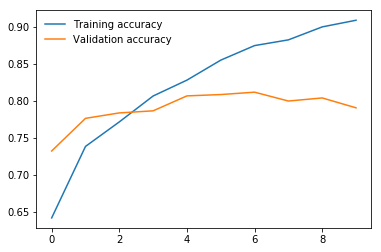

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_a, label='Training accuracy')
plt.plot(valid_a, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()

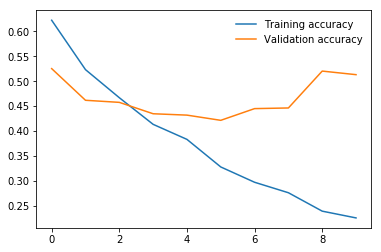

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_l, label='Training accuracy')
plt.plot(valid_l, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()